# GNN Scaling Analysis

In [1]:
import os
import sys
import pickle
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Local imports
sys.path.append('..')
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
def load_result(result_dir):
    history_files = glob.glob(os.path.join(result_dir, 'summaries_*.csv'))
    return pd.concat([pd.read_csv(f) for f in history_files], ignore_index=True)

def compute_mean_time(r):
    return r[r.epoch>0].train_time.mean()

def get_num_samples(config):
    return config['data']['n_train']

def compute_throughput(result, config):
    return get_num_samples(config) / compute_mean_time(result)

In [5]:
ls $SCRATCH/heptrkx/results_balanced

agnn_001/          scaling_agnn_n4/         scaling_cgpu_agnn_n2/
mpnn_001/          scaling_agnn_n64/        scaling_cgpu_agnn_n32/
scaling_agnn_n1/   scaling_agnn_n8/         scaling_cgpu_agnn_n4/
scaling_agnn_n16/  scaling_cgpu_agnn_n1/    scaling_cgpu_agnn_n64/
scaling_agnn_n2/   scaling_cgpu_agnn_n128/  scaling_cgpu_agnn_n8/
scaling_agnn_n32/  scaling_cgpu_agnn_n16/


## Cori Scaling

In [16]:
cori_result_dirs = sorted(glob.glob('/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_agnn_*'))
cori_result_dirs

['/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_agnn_n1',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_agnn_n16',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_agnn_n2',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_agnn_n32',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_agnn_n4',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_agnn_n64',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_agnn_n8']

In [17]:
cori_configs = [load_config_dir(d) for d in cori_result_dirs]
cori_results = [load_result(d) for d in cori_result_dirs]

In [18]:
cori_results[0]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.001,0.532952,2705.715812,26.302211,0,19.902824,0.314405,0.913898,8.404821
1,0.001,0.512183,2707.028533,26.299754,1,17.897756,0.305600,0.915803,6.495265
2,0.001,0.506814,2707.605350,26.293092,2,26.911603,0.276447,0.924408,5.539717
3,0.001,0.506300,2709.161770,26.288730,3,15.969161,0.280526,0.924701,5.260856


In [19]:
# Compute throughputs
ranks = np.array([c['n_ranks'] for c in cori_configs])
throughputs = np.array([compute_throughput(r, c) for (r, c) in zip(cori_results, cori_configs)])
idx = np.argsort(ranks)
ranks = ranks[idx]
throughputs = throughputs[idx]

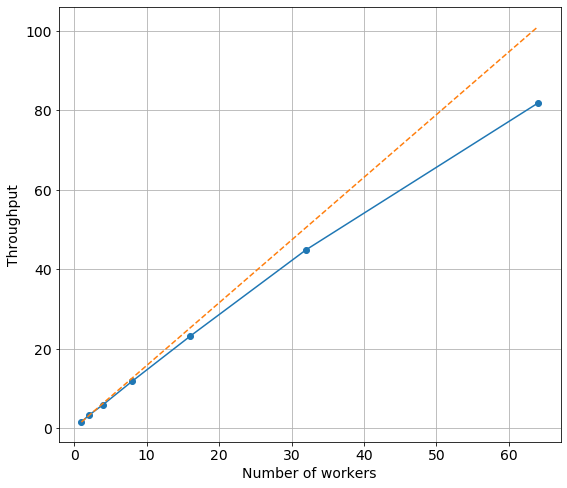

In [20]:
plt.figure(figsize=(9, 8))
plt.plot(ranks, throughputs, 'o-', label='Training')
plt.plot(ranks, ranks*throughputs[0], '--', label='Ideal')
plt.xlabel('Number of workers')
plt.ylabel('Throughput')
plt.grid()

## Cori GPU scaling

In [11]:
cgpu_result_dirs = sorted(glob.glob('/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_cgpu_agnn_*'))
cgpu_result_dirs

['/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_cgpu_agnn_n1',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_cgpu_agnn_n128',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_cgpu_agnn_n16',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_cgpu_agnn_n2',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_cgpu_agnn_n32',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_cgpu_agnn_n4',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_cgpu_agnn_n64',
 '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/scaling_cgpu_agnn_n8']

In [12]:
cgpu_configs = [load_config_dir(d) for d in cgpu_result_dirs]
cgpu_results = [load_result(d) for d in cgpu_result_dirs]

In [13]:
cgpu_results[0]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.001,0.498968,2710.859385,26.299892,0,14.455101,0.299191,0.907628,3.004500
1,0.001,0.479765,2734.451439,26.377645,1,14.120042,0.295159,0.909504,2.917482
2,0.001,0.435088,2782.397767,26.637816,2,14.157034,0.238081,0.911901,2.897545
3,0.001,0.336464,2823.701282,26.830034,3,13.751545,0.153901,0.937600,2.876455


In [14]:
# Compute throughputs
ranks = np.array([c['n_ranks'] for c in cgpu_configs])
throughputs = np.array([compute_throughput(r, c) for (r, c) in zip(cgpu_results, cgpu_configs)])
idx = np.argsort(ranks)
ranks = ranks[idx]
throughputs = throughputs[idx]

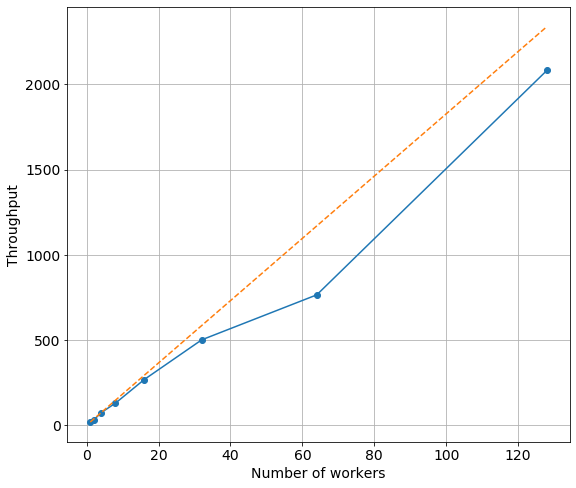

In [15]:
plt.figure(figsize=(9, 8))
plt.plot(ranks, throughputs, 'o-', label='Training')
plt.plot(ranks, ranks*throughputs[0], '--', label='Ideal')
plt.xlabel('Number of workers')
plt.ylabel('Throughput')
plt.grid()